In [94]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [24]:
# set ticker
ticker = "MSFT"

# set timeframe for data
start = '2000-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,62013600


### Filter the dataset

In [84]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes. Set threshold at +/- 0.01%
signals_df['Target'] = (
    (np.where(signals_df['Actual Returns'] > 0.01, 1.0, 0.0)) + 
    (np.where(signals_df['Actual Returns'] < -0.01, -1.0, 0.0))
)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,Target
Date,,,
2000-01-04,56.31250,-0.033780,-1.0
2000-01-05,56.90625,0.010544,1.0
2000-01-06,55.00000,-0.033498,-1.0
2000-01-07,55.71875,0.013068,1.0
2000-01-10,56.12500,0.007291,0.0


,Close,Actual Returns,Target
Date,,,
2020-12-24,222.750000,0.007827,0.0
2020-12-28,224.960007,0.009921,0.0
2020-12-29,224.149994,-0.003601,0.0
2020-12-30,221.679993,-0.011019,-1.0
2020-12-31,222.419998,0.003338,0.0


## Generate trading signals
---

### Bollinger Bands

In [98]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bankds
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']


bb_df

,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,
2000-01-04,56.312500,-0.033780,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2000-01-05,56.906250,0.010544,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2000-01-06,55.000000,-0.033498,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2000-01-07,55.718750,0.013068,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2000-01-10,56.125000,0.007291,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,222.750000,0.007827,0.0,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0
2020-12-28,224.960007,0.009921,0.0,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0
2020-12-29,224.149994,-0.003601,0.0,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

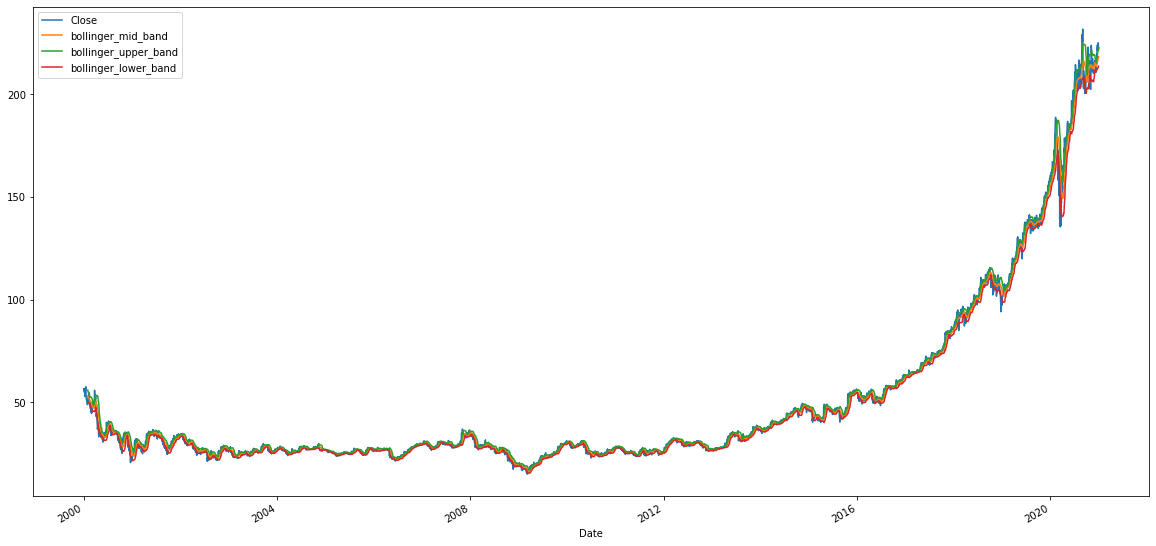

In [99]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [100]:
# Calculate the strategy returns and add them to the signals_df DataFrame
bb_df['Strategy Returns'] = bb_df['Actual Returns'] * bb_df['bollinger_signal'].shift()

# Review the DataFrame
display(bb_df.head())
display(bb_df.tail())

,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Strategy Returns
Date,,,,,,,,,,,
2000-01-04,56.31250,-0.033780,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2000-01-05,56.90625,0.010544,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2000-01-06,55.00000,-0.033498,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.0
2000-01-07,55.71875,0.013068,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2000-01-10,56.12500,0.007291,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Strategy Returns
Date,,,,,,,,,,,
2020-12-24,222.750000,0.007827,0.0,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0,-0.007827
2020-12-28,224.960007,0.009921,0.0,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0,-0.009921
2020-12-29,224.149994,-0.003601,0.0,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0,0.003601
2020-12-30,221.679993,-0.011019,-1.0,217.827999,4.528015,222.356014,213.299984,0.0,0.0,0.0,0.011019
2020-12-31,222.419998,0.003338,0.0,218.180499,4.600429,222.780928,213.580070,0.0,0.0,0.0,0.000000


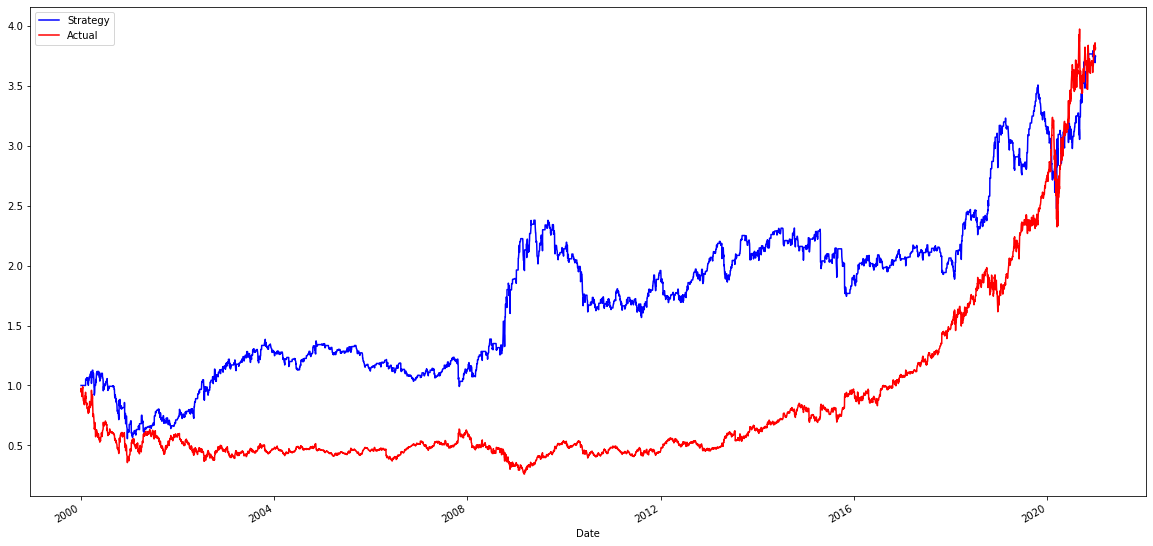

This trading signal has produced an average of 1.755163794378829% alpha from 2000-01-05 00:00:00 to 2020-12-31 00:00:00


In [133]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')

ax1 = (1 + bb_df['Strategy Returns']).cumprod().plot(color='blue', grid=True, label='Strategy')
ax2 = (1 + bb_df['Actual Returns']).cumprod().plot(color='red', grid=False, secondary_y=False, label='Actual')

h1, l1 = ax1.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()


alpha = ((1 + bb_df['Strategy Returns']).cumprod().mean()) - ((bb_df['Actual Returns']).cumprod().mean())
series_begin = X.index.min()
series_end = X.index.max()
print(f'This trading signal has produced an average of {alpha}% alpha from {series_begin} to {series_end}')

### Split the data into training and testing datasets